In [35]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random   # added
from sklearn.metrics import mean_squared_error

import tensorflow as tf

print(tf.__version__)
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))
print("Logical GPUs:", tf.config.list_logical_devices('GPU'))

# tf.debugging.set_log_device_placement(True)

from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Activation
# from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from tensorflow.keras.regularizers import l2


from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow import GradientTape

2.10.0
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


<b> Loading Data </b>



In [36]:

file_path = r'E:\07012018\data.txt'

steering_angles = []
filenames = []

with open(file_path, 'r') as file:
    for line in file:
        # Split to remove extraneous time data
        parts = line.split(',')

        # Split again to separate filename from steering angle
        components = parts[0].split()

        # Construct the full file path for the image
        filename = os.path.join(r'E:\07012018\data', components[0])

        # Convert steering angle from degrees to radians
        steering_angle = float(components[1]) * (np.pi / 180)

        # Append each to the lists
        filenames.append(filename)
        steering_angles.append(steering_angle)

print(f"Size of dataset: {len(steering_angles)}")

Size of dataset: 63825


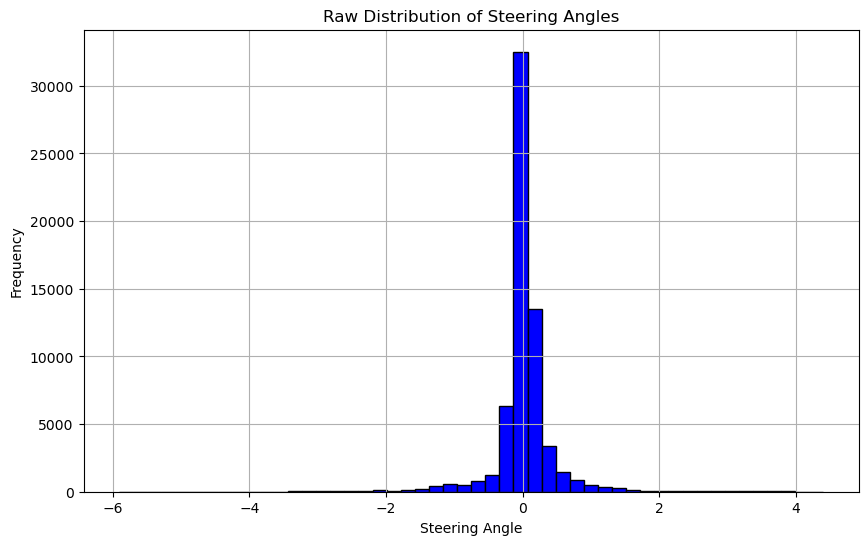

In [37]:
# Plot the distribution of steering angles
plt.figure(figsize=(10, 6))
plt.hist(steering_angles, bins=50, color='blue', edgecolor='black')

plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.title('Raw Distribution of Steering Angles')
plt.grid(True)
plt.show()

In [38]:
# 80% train, 20% validation
split_index = int(len(filenames) * 0.8)  
train_filenames = filenames[:split_index]
val_filenames = filenames[split_index:]

# Dictionary to map each filename to its steering angle
labels = {filenames[i]: steering_angles[i] for i in range(len(filenames))}

print(f"Training samples: {len(train_filenames)}")
print(f"Validation samples: {len(val_filenames)}")

Training samples: 51060
Validation samples: 12765


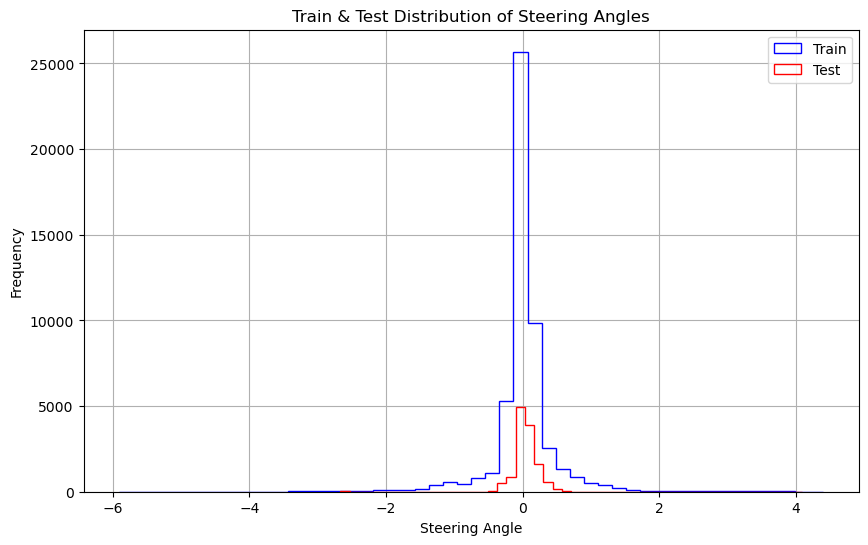

In [39]:
# Plot the distribution of steering angles split into training and testing data
plt.figure(figsize=(10, 6))
plt.hist(steering_angles[:split_index], bins=50, color='blue', histtype ='step',label='Train')
plt.hist(steering_angles[split_index:], bins=50, color='red', histtype ='step',label='Test')

plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.title('Train & Test Distribution of Steering Angles')
plt.legend()
plt.grid(True)
plt.show()

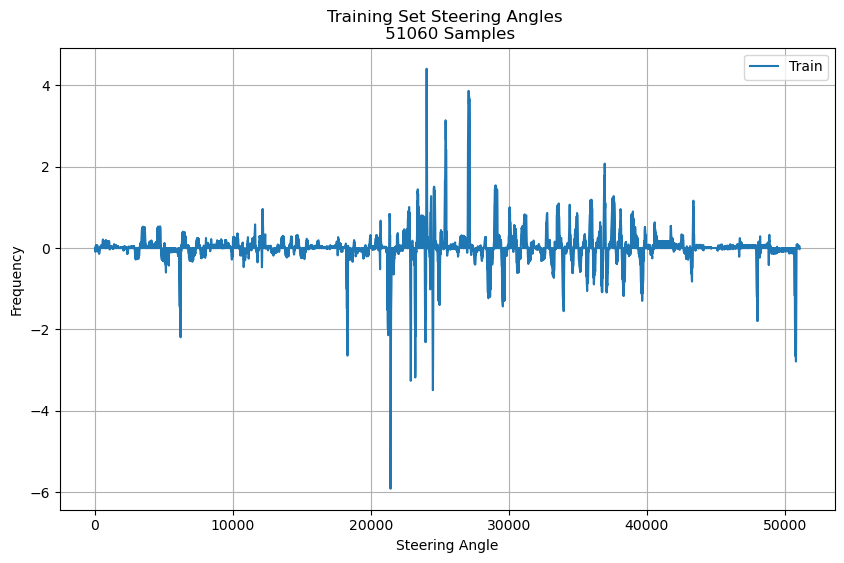

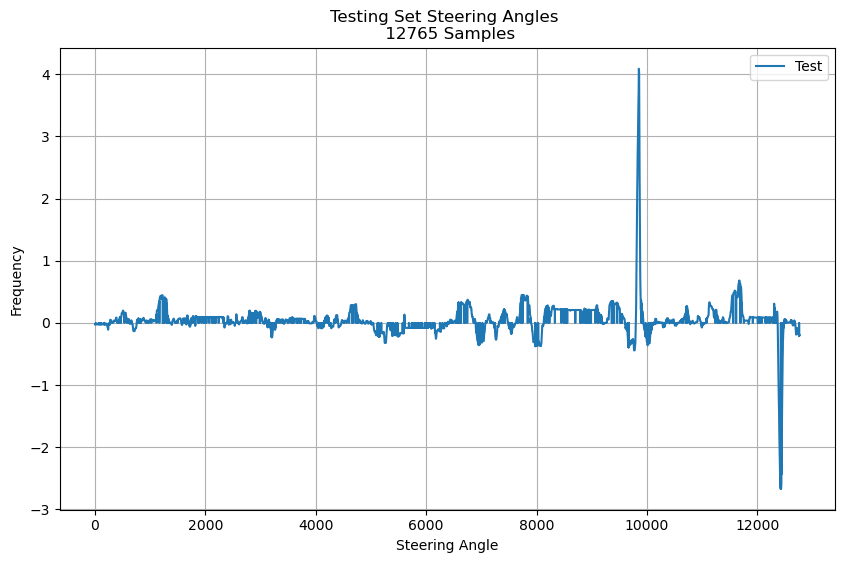

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(steering_angles[:split_index], label='Train')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.title(f'Training Set Steering Angles \n {len(steering_angles[:split_index])} Samples')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steering_angles[split_index:], label='Test')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.title(f'Testing Set Steering Angles \n {len(steering_angles[split_index:])} Samples')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
class DataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=32, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes for the current batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        # Select file paths for the batch
        images_temp = [self.images[i] for i in indexes]
        # Generate data
        X, y = self.__data_generation(images_temp)
        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_paths):
        def preprocess_lane_features(img):
            height, width = img.shape[:2]

            # Step 1: ROI mask
            roi_mask = np.zeros((height, width), dtype=np.uint8)
            polygon = np.array([[
                (0, height),
                (width, height),
                (int(width * 0.7), int(height * 0.5)),
                (int(width * 0.5), int(height * 0.5))
            ]], np.int32)
            cv2.fillPoly(roi_mask, polygon, 255)

            # yellow detection
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
            L_lab, A_lab, B_lab = cv2.split(lab)
            B_blur = cv2.blur(B_lab, (10, 10))
            yellow_mask = (B_lab > B_blur + 10)  # brighter yellow than local mean

            # Step 2: Convert to HLS
            hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            h, l, s = cv2.split(hls)

            # Step 3: Local mean filtering
            kernel_size = (10, 10)
            h_blur = cv2.blur(h, kernel_size)
            l_blur = cv2.blur(l, kernel_size)
            s_blur = cv2.blur(s, kernel_size)

            white_mask = (
                (l > l_blur + 5) &
                (s < s_blur)
            )

            color_mask = np.zeros_like(h, dtype=np.uint8)
            color_mask[yellow_mask | white_mask] = 255
            color_mask = cv2.bitwise_and(color_mask, roi_mask)

            # Step 5: Mask + Canny edge detection
            masked = cv2.bitwise_and(img, img, mask=color_mask)
            gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray, (5, 5), 0)
            edges = cv2.Canny(blur, 50, 150)

            # Step 6: Hough line detection
            lines = cv2.HoughLinesP(
                edges,
                rho=1,
                theta=np.pi / 180,
                threshold=50,
                minLineLength=20,
                maxLineGap=20
            )

            # Step 7: Draw filtered lines on darkened background
            overlay = (img * 0.3).astype(np.uint8)
            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    slope = (y2 - y1) / (x2 - x1 + 1e-5)
                    length = np.hypot(x2 - x1, y2 - y1)

                    # Filter out nearly horizontal lines and very short segments
                    if 0.3 < abs(slope) < 2.0 and length > 40:
                        cv2.line(overlay, (x1, y1), (x2, y2), (255, 255, 0), 3)  # bright cyan

            return overlay
        
        X, y = [], []
        for p in image_paths:
            img = cv2.imread(p)
            ang = self.labels[p]
        
            if self.augment:
                if random.random() < self.flip_prob:
                    img = cv2.flip(img, 1)
                    ang = -ang
                if random.random() < 0.5:
                    img, off = self._random_rotation(img)
                    ang += off
                if random.random() < self.bright_prob:
                    img = self._random_brightness(img)
        
            # Apply lane feature preprocessing
            img = preprocess_lane_features(img)
        
            # Crop and resize for model
            img = cv2.resize(img[-256:], (128, 64))
            img = img[:, :, ::-1] / 255.0
        
            X.append(img.astype(np.float32))
            y.append(ang)
        
        return np.asarray(X), np.asarray(y).astype(np.float32)
            


In [42]:
import cv2, numpy as np, random
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(
        self, images, labels,
        batch_size=32, shuffle=True,
        augment=True,              # <- enable/disable on the fly
        rot_range=2,               # degrees (±) for small in-plane rotations
        flip_prob=0.5,
        bright_prob=0.5
    ):
        self.images      = images
        self.labels      = labels
        self.batch_size  = batch_size
        self.shuffle     = shuffle
        self.augment     = augment
        self.rot_range   = rot_range
        self.flip_prob   = flip_prob
        self.bright_prob = bright_prob
        self.on_epoch_end()

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        idx = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        image_paths = [self.images[i] for i in idx]
        return self.__data_generation(image_paths)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # ---------- augmentation utilities ----------
    @staticmethod
    def _random_brightness(img, min_factor=0.4, max_factor=1.6):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hsv[..., 2] = np.clip(hsv[..., 2] *
                              random.uniform(min_factor, max_factor), 0, 255)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    def _random_rotation(self, img):
        angle = random.uniform(-self.rot_range, self.rot_range)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REPLICATE)
        # Steering-angle compensation: camera rotations ≅ steering offsets,
        # use small factor; tweak to taste (1 deg ≈ 0.002 rad)
        steer_offset = np.deg2rad(angle) * 0.5
        return img, steer_offset

    def __data_generation(self, image_paths):
        def preprocess_lane_features(img):
            height, width = img.shape[:2]

            # Step 1: ROI mask
            roi_mask = np.zeros((height, width), dtype=np.uint8)
            polygon = np.array([[
                (0, height),
                (width, height),
                (int(width * 0.7), int(height * 0.5)),
                (int(width * 0.5), int(height * 0.5))
            ]], np.int32)
            cv2.fillPoly(roi_mask, polygon, 255)

            # yellow detection
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
            L_lab, A_lab, B_lab = cv2.split(lab)
            B_blur = cv2.blur(B_lab, (10, 10))
            yellow_mask = (B_lab > B_blur + 10)  # brighter yellow than local mean

            # Step 2: Convert to HLS
            hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            h, l, s = cv2.split(hls)

            # Step 3: Local mean filtering
            kernel_size = (10, 10)
            h_blur = cv2.blur(h, kernel_size)
            l_blur = cv2.blur(l, kernel_size)
            s_blur = cv2.blur(s, kernel_size)

            white_mask = (
                (l > l_blur + 5) &
                (s < s_blur)
            )

            color_mask = np.zeros_like(h, dtype=np.uint8)
            color_mask[yellow_mask | white_mask] = 255
            color_mask = cv2.bitwise_and(color_mask, roi_mask)

            # Step 5: Mask + Canny edge detection
            masked = cv2.bitwise_and(img, img, mask=color_mask)
            gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray, (5, 5), 0)
            edges = cv2.Canny(blur, 50, 150)

            # Step 6: Hough line detection
            lines = cv2.HoughLinesP(
                edges,
                rho=1,
                theta=np.pi / 180,
                threshold=50,
                minLineLength=20,
                maxLineGap=20
            )

            # Step 7: Draw filtered lines on darkened background
            overlay = (img * 0.3).astype(np.uint8)
            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    slope = (y2 - y1) / (x2 - x1 + 1e-5)
                    length = np.hypot(x2 - x1, y2 - y1)

                    # Filter out nearly horizontal lines and very short segments
                    if 0.3 < abs(slope) < 2.0 and length > 40:
                        cv2.line(overlay, (x1, y1), (x2, y2), (255, 255, 0), 3)  # bright cyan

            return overlay
    
        X, y = [], []
        for p in image_paths:
            img = cv2.imread(p)
            ang = self.labels[p]
    
            if self.augment:
                # if random.random() < self.flip_prob:
                #     img = cv2.flip(img, 1)
                #     ang = -ang
                if random.random() < 0.5:
                    img, off = self._random_rotation(img)
                    ang += off
                if random.random() < self.bright_prob:
                    img = self._random_brightness(img)
    
            # Apply lane feature preprocessing
            img = preprocess_lane_features(img)
    
            # Crop and resize for model
            img = cv2.resize(img[-256:], (128, 64))
            img = img[:, :, ::-1] / 255.0
    
            X.append(img.astype(np.float32))
            y.append(ang)
    
        return np.asarray(X), np.asarray(y).astype(np.float32)


In [43]:
def nvidia_model(input_shape=(64, 128, 3)):
    model = Sequential()
    # 5x5 Convolutional layers with stride 2x2
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='elu', input_shape=input_shape))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    # 3x3 Convolutional layers with stride 1x1
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    # Flatten
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.25))
    # Output layer
    model.add(Dense(1, activation='linear'))
    return model

In [44]:
def opt_nvidia_model(input_shape=(64, 128, 3), l2_reg=1e-4):
    model = Sequential()
    
    # 5x5 Conv layers with stride 2x2
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='elu',
                     kernel_regularizer=l2(l2_reg), input_shape=input_shape))
    model.add(BatchNormalization())

    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())

    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())

    # 3x3 Conv layers with stride 1x1
    model.add(Conv2D(64, (3, 3), activation='elu',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='elu',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    # Fully connected layers with L2 + BatchNorm
    model.add(Dense(100, activation='elu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(50, activation='elu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(10, activation='elu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(1, activation='linear'))  

    print(model.summary)

    return model


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, SpatialDropout2D,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.regularizers import l2


def opt_nvidia_model_light(input_shape=(64, 128, 3),
                           l2_reg: float = 1e-4,
                           dropout_rate: float = 0.3) -> Sequential:
    """
    Leaner Sequential network for steering-angle prediction.
    • No cropping/normalisation (handled in the generator)
    • Three convolutional stages → GAP → two small dense layers
    """

    model = Sequential()

    # ----- 5×5 conv stem ----------------------------------------------------
    model.add(
        Conv2D(24, (5, 5), strides=(2, 2), padding="same",
               use_bias=False, kernel_regularizer=l2(l2_reg),
               input_shape=input_shape)
    )
    model.add(BatchNormalization())
    model.add(Activation("elu"))
    model.add(SpatialDropout2D(dropout_rate))

    model.add(
        Conv2D(36, (5, 5), strides=(2, 2), padding="same",
               use_bias=False, kernel_regularizer=l2(l2_reg))
    )
    model.add(BatchNormalization())
    model.add(Activation("elu"))
    model.add(SpatialDropout2D(dropout_rate))

    model.add(
        Conv2D(48, (3, 3), strides=(1, 1), padding="same",
               use_bias=False, kernel_regularizer=l2(l2_reg))
    )
    model.add(BatchNormalization())
    model.add(Activation("elu"))
    model.add(SpatialDropout2D(dropout_rate))

    # ----- global pooling & compact dense head -----------------------------
    model.add(Flatten())

    model.add(Dense(48, activation="elu", kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(16, activation="elu", kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="linear", name="steering"))

    # print callable, mimicking your original style
    print(model.summary)

    return model


In [46]:
train_generator = DataGenerator(train_filenames, labels, batch_size=32, shuffle=True)
val_generator = DataGenerator(val_filenames, labels, batch_size=32, shuffle=False)

reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=2,verbose=True)

early_stopping_monitor = EarlyStopping(patience=3, monitor='val_loss', mode='auto')

#model = opt_nvidia_model()
#model.compile(optimizer='adam', loss='mse', metrics =["accuracy"])

model = opt_nvidia_model_light()
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_generator, 
    epochs=5,
    validation_data=val_generator,
    use_multiprocessing=False,
    workers=8,
    max_queue_size=10
)

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x0000022C0F6A8898>>
Epoch 1/5
1595/1595 [==============================] - 221s 137ms/step - loss: 0.3423 - mae: 0.3356 - val_loss: 0.1458 - val_mae: 0.1950
Epoch 2/5
1595/1595 [==============================] - 124s 78ms/step - loss: 0.2247 - mae: 0.2245 - val_loss: 0.1416 - val_mae: 0.1662
Epoch 3/5
1595/1595 [==============================] - 125s 78ms/step - loss: 0.2284 - mae: 0.2205 - val_loss: 0.1455 - val_mae: 0.1602
Epoch 4/5
1595/1595 [==============================] - 120s 75ms/step - loss: 0.2375 - mae: 0.2196 - val_loss: 0.1858 - val_mae: 0.1804
Epoch 5/5
1595/1595 [==============================] - 120s 75ms/step - loss: 0.2455 - mae: 0.2162 - val_loss: 0.1832 - val_mae: 0.1740


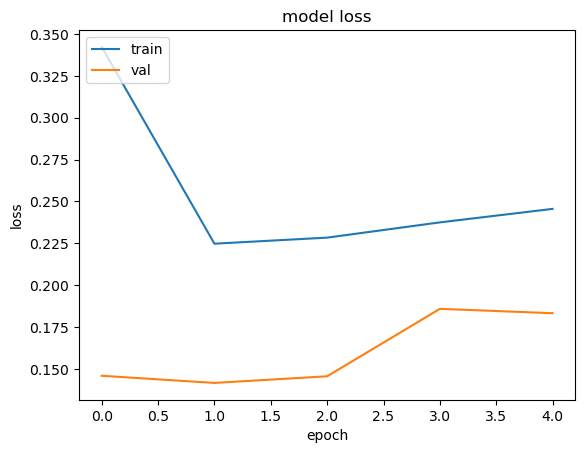

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
print(history.history)

{'loss': [0.3422544002532959, 0.22473736107349396, 0.22835537791252136, 0.23746150732040405, 0.24552381038665771], 'mae': [0.3356495201587677, 0.22449126839637756, 0.22049692273139954, 0.21958839893341064, 0.21624404191970825], 'val_loss': [0.14584754407405853, 0.14157581329345703, 0.1455356627702713, 0.18582294881343842, 0.1832115352153778], 'val_mae': [0.19501249492168427, 0.16620436310768127, 0.16018393635749817, 0.1804284006357193, 0.1740158051252365]}


In [49]:
model.save("model.keras")
print("Model saved successfully to model.keras")
model.summary()

Model saved successfully to model.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 64, 24)        1800      
                                                                 
 batch_normalization_5 (Batc  (None, 32, 64, 24)       96        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 32, 64, 24)        0         
                                                                 
 spatial_dropout2d_3 (Spatia  (None, 32, 64, 24)       0         
 lDropout2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 32, 36)        21600     
                                                                 
 batch_normali

398/398 [==============================] - 1s 3ms/step
Validation MSE: 0.111579


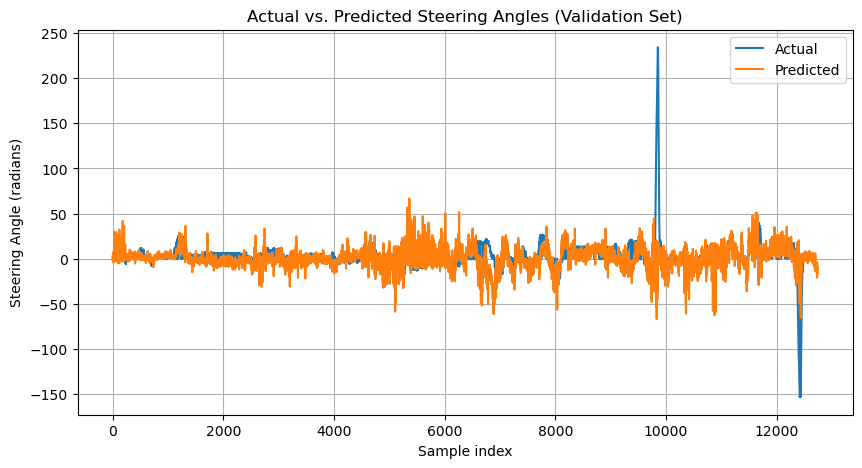

In [50]:
val_X = []
val_y_true = []
for i in range(len(val_generator)):
    X_batch, y_batch = val_generator[i]
    val_X.append(X_batch)
    val_y_true.append(y_batch)

val_X = np.concatenate(val_X, axis=0)
val_y_true = np.concatenate(val_y_true, axis=0)

val_y_pred = model.predict(val_X)
val_y_pred = val_y_pred.flatten()

mse = mean_squared_error(val_y_true, val_y_pred)
print(f"Validation MSE: {mse:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(val_y_true * (180 / np.pi), label='Actual')
plt.plot(val_y_pred * (180 / np.pi), label='Predicted')
plt.title('Actual vs. Predicted Steering Angles (Validation Set)')
plt.xlabel('Sample index')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
def get_img_array(img_path):

    image = cv2.imread(img_path)
    image = image[-256:]  # shape: (150, width, 3)
    image = cv2.resize(image, (128, 64))
    image = image / 255
    return np.expand_dims(image, axis=0)


def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output, 
            model.output,                                  
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)  
        steering_angle = predictions[:, 0]

    grads = tape.gradient(steering_angle, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    #pooled_grads = tf.reduce_sum(tf.abs(grads), axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]  # remove batch dim => shape (h, w, channels)
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    max_val = np.max(heatmap) if np.max(heatmap) != 0 else 1e-10
    heatmap /= max_val


    return heatmap

def save_and_display_gradcam(img_path, heatmap, alpha=0.4, out_path="cam.jpg"):
    """
    Overlays a Grad-CAM heatmap on the original image and shows the result using matplotlib.

    Args:
        img_path (str): Path to the original image (for display).
        heatmap (np.ndarray): Grad-CAM heatmap in [0,1], shape possibly (h, w).
        alpha (float): Transparency factor for blending heatmap (0..1).
        out_path (str): Where to save the final overlay (in BGR format).
    """

    original_bgr = cv2.imread(img_path)

    # Convert to RGB for plotting
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

    heatmap_resized = cv2.resize(heatmap, (original_bgr.shape[1], original_bgr.shape[0]))
    # Convert heatmap to [0,255]
    heatmap_resized = np.uint8(255 * heatmap_resized)


    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_bgr = cv2.addWeighted(
        original_bgr, 1 - alpha,
        heatmap_color, alpha,
        0
    )

    # Convert back to RGB for display
    superimposed_rgb = cv2.cvtColor(superimposed_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(heatmap)
    plt.show()

    # 6. Display with matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].imshow(original_rgb)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(superimposed_rgb)
    axes[1].set_title("Grad-CAM Overlay")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Grad-CAM saved to {out_path}")


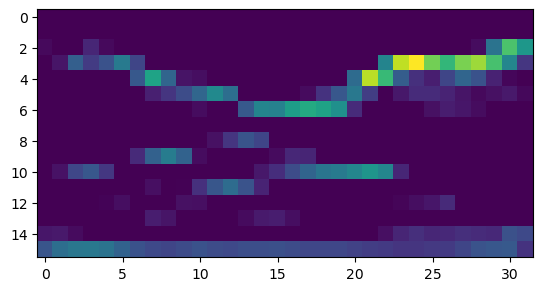

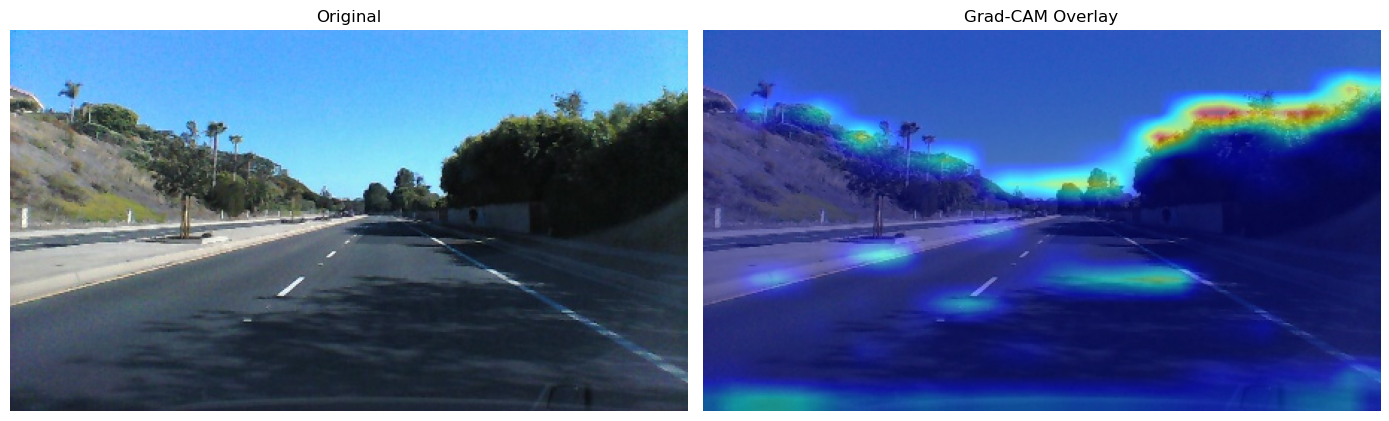

Grad-CAM saved to cam_overlay.jpg


In [ ]:
last_conv_layer_name = "conv2d_5" 

# A sample image path (that the model sees in training format)
img_path = r"E:\07012018\data\0.jpg"

# 1) Convert the image to the correct input array
img_array = get_img_array(img_path)  # shape (1,66,200,3)

# 2) Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(
    img_array=img_array,
    model=model,
    last_conv_layer_name=last_conv_layer_name
)

# 3) Overlay heatmap and display
save_and_display_gradcam(img_path, heatmap, alpha=0.5, out_path="cam_overlay.jpg")

In [ ]:
# Select a convolutional layer
layer_name = 'conv2d_7'  # Change to the layer you want to visualize
layer = model.get_layer(name=layer_name)

# Get the weights of the layer
filters, biases = layer.get_weights()

# Normalize filter values for better visualization
filters_min = filters.min()
filters_max = filters.max()
filters = (filters - filters_min) / (filters_max - filters_min)

# Plot filters
n_filters = min(filters.shape[3], 16)  # Show up to 16 filters
fig, axes = plt.subplots(1, n_filters, figsize=(20, 5))

for i in range(n_filters):
    f = filters[:, :, :, i]  # Extract i-th filter
    f = f[:, :, 0]  # If it's RGB, take one channel
    
    axes[i].imshow(f, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i}')

plt.show()


ValueError: No such layer: conv2d_7. Existing layers are: ['conv2d', 'batch_normalization', 'activation', 'spatial_dropout2d', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'spatial_dropout2d_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'spatial_dropout2d_2', 'flatten', 'dense', 'batch_normalization_3', 'dropout', 'dense_1', 'batch_normalization_4', 'dropout_1', 'steering'].